<h1><center>Notebook 5 : Dimensions plot </center></h1>

<h2>Instructions for this notebook</h2>


This notebook was written by Paul Platzer. It accompanies the following scientific publication:<br>
"Weather Regime Dimensions: from Random to Multi-fractal"<br>
By Paul Platzer, Bertrand Chapron, and Gabriele Messori.<br>
<b> add doi, date...etc. </b>

It is part of six notebooks that allow to reproduce the figures of the article. It must be used in conjunction with 500mb geopotential height data from ERA5 (last download from october 18th, 2023), as specified in the body text of the article.

What this notebook does:

<ol>
    <li> It opens preprocessed ERA5 data (10day-smoothed anomalies projected on winter-time EOFs), the results of the GMM fit, and the stochastic twins.</li>
    <li> It computes weather-regime indices based on ERA5 projected data, stochastic twin data, and GMM fit parameters. </li>
    <li> It loads pre-computed dimensions. </li>
    <li> It computes some statistics on dimension, including dimension anomaly with respect to a 1-month climatology of dimension, and average $\pm$ standard-deviation of dimension around weather regime maximum (WRI life-cycles). </li>
    <li> It plots: dimension computed from ERA5 vs. dimension computed from stochastic twins, dimension anomaly mean $\pm$ standard-deviation around weather-regime life-cycles, dimension anomaly vs. peak weather-regime index. </li>
</ol>

To use properly this notebook, you must:

<ol>
    <li> Have previously run "Notebook0-ERA5_pretreatment.ipynb", "Notebook1-GMM_fit.ipynb", "Notebook2-Stochastic_twin_generation.ipynb" and "Notebook4-Dimensions_computation.ipynb".</li>
    <li> Run the whole notebook once.</li>
</ol>

Note that for a correct display of the figures, you must run all cells in the order they are displayed here. In particular, the variable "LC_length" is not the same depending on which plot you want to reproduce. Note that this notebook also allows to make sensitivity test:

<ol>
    <li> By changing the value of "LC_length" you can test the sensitivity of the plots to the minimum length of weather-regime life-cycles. </li>
    <li> By changing the value of "i_K" (and therefore of K[i_K], i.e. the number of analogues used to compute dimensions) you can test the sensitivity of the results to the bandwidth used to compute dimensions.</li>
</ol>

Finally, note that, for this code to work on your machine, you should:

<ol>
    <li> Have download the libraries listed in the first two cells. </li>
    <li> Use python 3 : this code was tested using python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0] </li>
    <li> Have enough memory and computing resources. If not, you might have to modify the code to make it work. The code was run using a Dell Inc. Precision 7550 which has 33G of RAM and setting the same amount of swap space, and for processing we have Intel® Core™ i7-10875H CPU @ 2.30GHz × 16, with graphics card NVIDIA Corporation TU104GLM [Quadro RTX 4000 Mobile / Max-Q] / Mesa Intel® UHD Graphics (CML GT2). </li>
</ol>

In [1]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from sklearn.neighbors import KDTree, NearestNeighbors
from sklearn.metrics import pairwise_distances
import sys
sys.path.append('../functions/.')
from functions import scatter_hist

In [3]:
# list of color-blind-friendly colors
cols = ['k', '#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# folders where data and figures generated through this notebook will be stored
data_folder = '../outputs/data/'
figure_folder = '../outputs/figures/'

# I. Load preprocessed ERA5, GMM parameters and stochastic twins

In [5]:
# load
npzfile = np.load(data_folder + 'GMM_params.npz')
means = npzfile['means']
covs = npzfile['covs']
weights = npzfile['weights']
nclus = npzfile['nclus']
cov_type = npzfile['cov_type']
ndim_gmm = npzfile['ndim_gmm']
random_state_gmm = npzfile['random_state_gmm']
regime_names = npzfile['regime_names']
regime_short_names = npzfile['regime_short_names']
regime_attribution = npzfile['regime_attribution']
regime_attribution_distance = npzfile['regime_attribution_distance']
Ndays = npzfile['Ndays']
Ndays_kmeans = npzfile['Ndays_kmeans']
Ndays_tot = npzfile['Ndays_tot']

In [6]:
allpcs = xr.open_dataset(data_folder + 'pcs.nc')['pseudo_pcs']
eofs = xr.open_dataset(data_folder + 'eofs.nc')['eofs']
pourc_EOF = xr.open_dataset(data_folder + 'pourc_eofs.nc')['variance_fractions']

In [7]:
# normalize pcs but keep relative variances
pcs_norm = allpcs / (allpcs.sel(mode=0)).std(dim='time')

In [8]:
npzfile = np.load(data_folder + 'stoch_twins.npz')
X = npzfile['X']
ndim_gmm = npzfile['ndim_gmm']
rho = npzfile['rho']
scaling = npzfile['scaling']
Ntwins = X.shape[0]
L = X.shape[1]

# II. Compute weather regime index (WRI)

In [9]:
index = np.zeros( ( Ntwins , L , len(means) ) ,  dtype='float64')
for k in range(Ntwins):
    for i in range(len(means)):
        index[k,:,i] = np.sum( X[k][:,:ndim_gmm]*means[i] , axis=1)
        index[k,:,i] -= np.mean( index[k,:,i] )
        index[k,:,i] /= np.std( index[k,:,i] )    

In [10]:
c_index = np.zeros( ( Ntwins , L , len(means) ) ,  dtype='float64')
for k in range(Ntwins):
    for i in range(len(means)):
        c_index[k,:,i] = np.einsum( 'ij,jk,ik->i' , X[k][:,:ndim_gmm]-means[i] ,
                                   np.linalg.inv(covs[i]) , X[k][:,:ndim_gmm]-means[i] )

In [11]:
index_nat = np.zeros( ( len(pcs_norm), len(means) ) ,  dtype='float64')
for i in range(len(means)):
    index_nat[:,i] = np.sum( np.array(pcs_norm[:,:ndim_gmm])*means[i] , axis=1)
    index_nat[:,i] -= np.mean( index_nat[:,i] )
    index_nat[:,i] /= np.std( index_nat[:,i] )

In [12]:
c_index_nat = np.zeros( ( len(pcs_norm) , len(means) ) ,  dtype='float64')
for i in range(len(means)):
    c_index_nat[:,i] = np.einsum( 'ij,jk,ik->i' , pcs_norm[:,:ndim_gmm]-means[i] ,
                                 np.linalg.inv(covs[i]) , pcs_norm[:,:ndim_gmm]-means[i] )

# III. Load dimensions and compute dimension anomalies

Load.

In [13]:
npzfile = np.load(data_folder + 'dim_nat.npz')
dd_nat = npzfile['dd_nat']
dd_pcs = npzfile['dd_pcs']
K = npzfile['K']

In [14]:
npzfile = np.load(data_folder + 'dim_twins.npz')
dd_nat_twin = npzfile['dd_nat_twin']
dd_twin = npzfile['dd_twin']
K = npzfile['K']

In [15]:
np.mean(dd_nat)

30.02320161825847

Compute anomalies

In [16]:
# load time and day-of-year
npzfile = np.load(data_folder + 'time_doy.npz')
time_arr = npzfile['time_arr']
doy_arr = npzfile['doy_arr']

In [17]:
# Compute climatologies with a rolling window
dd_nat_clim = np.full((len(set(doy_arr)), len(K)), np.nan)
dd_pcs_clim = np.full((len(set(doy_arr)), len(K)), np.nan)
dd_nat_twin_clim = np.full((Ntwins, len(set(doy_arr)), len(K)), np.nan)
dd_twin_clim = np.full((Ntwins, len(set(doy_arr)), len(K)), np.nan)
window_anom_len = 30

for i in tqdm(range(len(set(doy_arr)))):
    day = list(set(doy_arr))[i]
    # Define the rolling window condition
    window_start = ( day - int(window_anom_len/2) ) % 366
    window_end = ( day + int(window_anom_len/2) ) % 366

    if window_start <= window_end:
        # No wrapping: days are within [window_start, window_end]
        condition = (doy_arr >= window_start) & (doy_arr <= window_end)
    else:
        # Wrapping: days are in [window_start, 366] or [1, window_end]
        condition = (doy_arr >= window_start) | (doy_arr <= window_end)

    # Compute climatologies
    dd_nat_clim[i] = np.mean(dd_nat[condition], axis=0)
    dd_pcs_clim[i] = np.mean(dd_pcs[condition], axis=0)
    dd_nat_twin_clim[:, i] = np.mean(dd_nat_twin[:, condition], axis=1)
    dd_twin_clim[:, i] = np.mean(dd_twin[:, condition], axis=1)

  0%|          | 0/92 [00:00<?, ?it/s]

In [18]:
## Compute anomalies
# Initialize with "raw" values
dd_nat_anom = np.copy( dd_nat )
dd_pcs_anom = np.copy( dd_pcs )
dd_nat_twin_anom = np.copy( dd_nat_twin )
dd_twin_anom = np.copy( dd_twin )
for i in tqdm(range(len(set(doy_arr)))):
    dd_nat_anom[doy_arr==list(set(doy_arr))[i]] -= dd_nat_clim[i]
    dd_pcs_anom[doy_arr==list(set(doy_arr))[i]] -= dd_pcs_clim[i]
    dd_nat_twin_anom[:,doy_arr==list(set(doy_arr))[i]] -= np.repeat( dd_nat_twin_clim[:,np.newaxis, i], 
                                                                    (doy_arr==list(set(doy_arr))[i]).sum() , axis=1 )
    dd_twin_anom[:,doy_arr==list(set(doy_arr))[i]] -= np.repeat( dd_twin_clim[:,np.newaxis, i], 
                                                                (doy_arr==list(set(doy_arr))[i]).sum() , axis=1 )

  0%|          | 0/92 [00:00<?, ?it/s]

# IV. Plot

## IV.A. Dimension from ERA5 vs. dimension from stochastic twins
ERA5 as targets, stochastic twins as analogues. Scatter-plot.

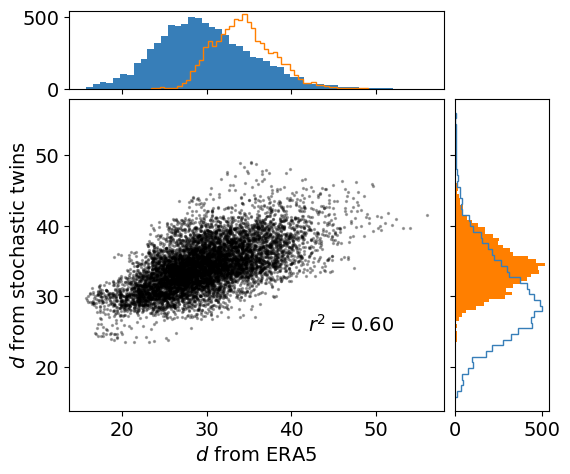

In [114]:
i_K = 30

fig = plt.figure(figsize=(6, 5), dpi=100)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

scatter_hist(dd_pcs[:,i_K], np.mean( dd_nat_twin[:,:,i_K] , axis=0 ), ax, ax_histx, ax_histy)

# ticks = np.arange(6,18+2,2)
# ax.set_xticks(ticks); ax.set_yticks(ticks)

ax.set_ylabel(r'$d$ from stochastic twins'); ax.set_xlabel(r'$d$ from ERA5')

ax.text( 42 , 25 , r'$r^2=$' + str(
             np.corrcoef( np.mean( dd_nat_twin[:,:,i_K] , axis=0 ) , 
            dd_pcs[:,i_K] )[0,1] )[:4]  )

plt.savefig(figure_folder + 'd_hist_K'+str(K[i_K])+'.png', bbox_inches='tight', dpi=150)
plt.show()

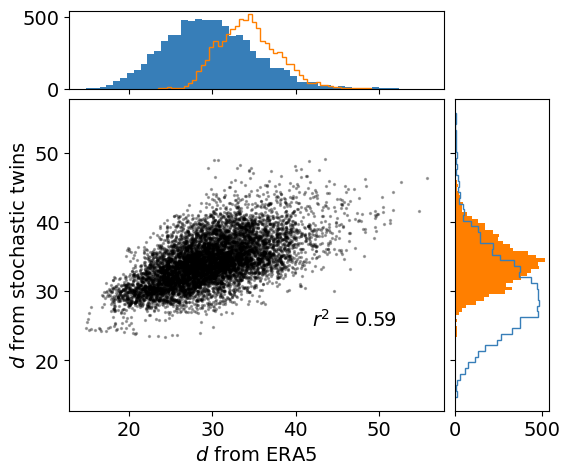

In [45]:
i_K = 30

fig = plt.figure(figsize=(6, 5), dpi=100)
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

scatter_hist(dd_nat[:,i_K], np.mean( dd_nat_twin[:,:,i_K] , axis=0 ), ax, ax_histx, ax_histy)

# ticks = np.arange(6,18+2,2)
# ax.set_xticks(ticks); ax.set_yticks(ticks)

ax.set_ylabel(r'$d$ from stochastic twins'); ax.set_xlabel(r'$d$ from ERA5')

ax.text( 42 , 25 , r'$r^2=$' + str(
             np.corrcoef( np.mean( dd_nat_twin[:,:,i_K] , axis=0 ) , 
            dd_nat[:,i_K] )[0,1] )[:4]  )

plt.savefig(figure_folder + 'd_hist_K'+str(K[i_K])+'_ERAnotproj.png', bbox_inches='tight', dpi=150)
plt.show()

Note that the correlation coefficient depends on how much analogs are used to compute the dimension. This is demonstrated in the following figure.

In [19]:
r2_K = np.zeros(len(K))
for i_K in range(len(K)):
    r2_K[i_K] = np.corrcoef( np.mean( dd_nat_twin[:,:,i_K] , axis=0 ) , 
                    dd_pcs[:,i_K] )[0,1]

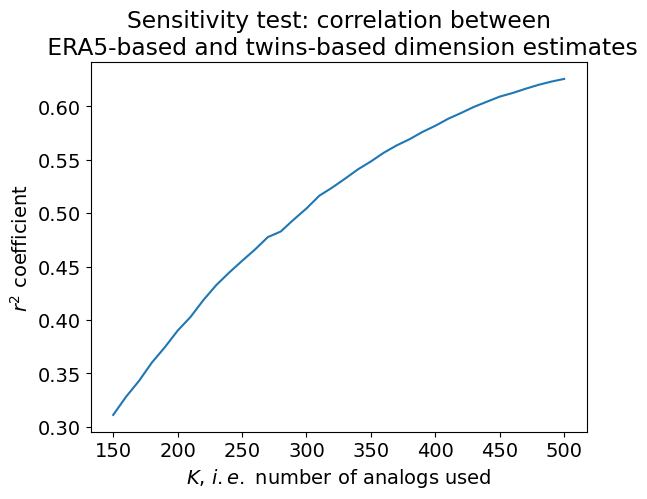

In [20]:
plt.figure()
plt.plot(K, r2_K)
plt.xlabel(r'$K$, $i.e.$ number of analogs used')
plt.ylabel(r'$r^2$ coefficient')
plt.title('Sensitivity test: correlation between\n ERA5-based and twins-based dimension estimates')
plt.savefig(figure_folder + 'r2_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

## IV.B. Average $\pm$std of dimension anomaly changes around maximum index

### IV.B.1. Plots using stochastic twins as analogues of ERA5 projected data

In [42]:
# # minimum length of life-cycle
LC_length = 5*2
# # minimum value of IWR for life-cycle definitino
thresh_IWR = 1
# # (half of whole) length over which to plot characteristics
plot_length = 15*2
t_plot = np.arange( - plot_length , plot_length + 1 )/2

IWR_plot_nat = []

dd_plot_nat = []
dd_plot_pcs = []
dd_plot_nat_twin = []

for i_regime in range(len(means)):
    
    IWR_plot__ = []
    dd_plot_nat__ = []
    dd_plot_pcs__ = []
    dd_plot_nat_twin__ = []
    
    
    t = np.array(plot_length) + 5
    while t < int(L) - 5 - max(LC_length , plot_length + 1):
        t += 1
        if np.product( index_nat[t:t+LC_length,i_regime] > thresh_IWR ):
            t_start = t.copy()
            t_end = t_start+LC_length
            while index_nat[t_end,i_regime] > thresh_IWR and t_end + 1 < L :
                t_end += 1
            t_max = t_start + np.argmax(index_nat[t_start:t_end,i_regime])
            
            if t_max < int(L) + 1 - plot_length:
                
                IWR_plot__.append( index_nat[t_max-plot_length:t_max+plot_length+1] )
                
                dd_plot_nat__.append( dd_nat_anom[t_max-plot_length:t_max+plot_length+1] )
                dd_plot_pcs__.append( dd_pcs_anom[t_max-plot_length:t_max+plot_length+1] )
                dd_plot_nat_twin__.append( dd_nat_twin_anom[:,t_max-plot_length:t_max+plot_length+1] )
                
            t = t_end.copy()
    
    IWR_plot_nat.append( IWR_plot__ )
    
    dd_plot_nat.append( np.array(dd_plot_nat__) )
    dd_plot_pcs.append( np.array(dd_plot_pcs__) )
    dd_plot_nat_twin.append( np.array(dd_plot_nat_twin__) )

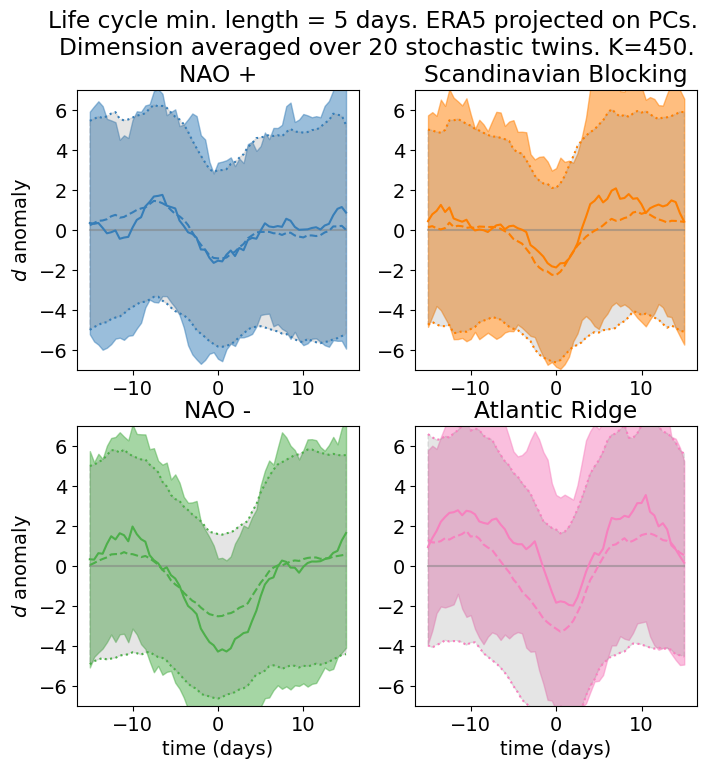

In [113]:
plt.figure(figsize=(8,8),dpi=100)
i_K = 30
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)
    
    plt.plot([-plot_length/2,plot_length/2] , [0]*2, '-', color='.5', alpha=.5)
    
    for j in range(2):
        if j == 0:
            plot_mean = np.mean( dd_plot_pcs[i_regime][:,:,i_K] , axis = 0)
            plot_std = np.std( dd_plot_pcs[i_regime][:,:,i_K] , axis = 0)
        else:
            plot_mean = np.mean( dd_plot_nat_twin[i_regime][:,:,:,i_K] , axis = (0,1))
            plot_std = np.std( dd_plot_nat_twin[i_regime][:,:,:,i_K] , axis = (0,1))
            
        plt.plot(t_plot, plot_mean, ['-','--'][j], color=cols[i_regime+1])
        plt.fill_between(t_plot, plot_mean - plot_std, plot_mean + plot_std,
                         ls = ['-','--'][j] , color=[cols[i_regime+1],'0.5'][j], alpha=[.5,.2][j])
        if j==1:
            plt.plot(t_plot, plot_mean - plot_std , ':', color=cols[i_regime+1])
            plt.plot(t_plot, plot_mean + plot_std , ':', color=cols[i_regime+1])
            
    plt.xlabel('time (days)'*( i_regime > 1 ))
    plt.ylabel(r'$d$ anomaly'*( i_regime % 2 == 0 ))
    plt.ylim([-7,7])
    plt.title(regime_names[i_regime])

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days. '
            +'ERA5 projected on PCs. \n'
            +'Dimension averaged over '+str(Ntwins)+' stochastic twins. K='+str(K[i_K])+'.')
plt.savefig(figure_folder + 'd_life-cycle_twins_as_analogs.png', dpi=150, bbox_inches='tight')
plt.show()

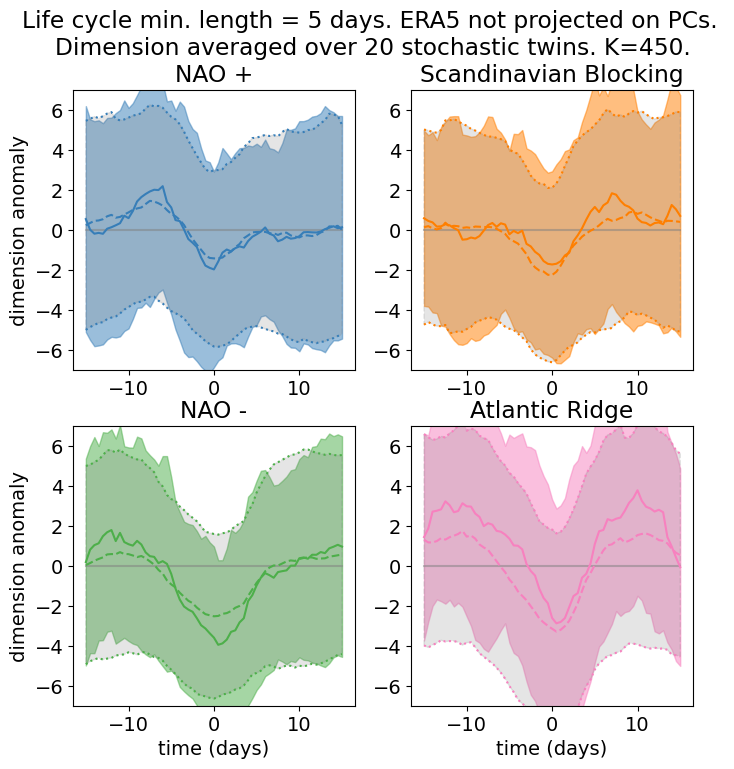

In [43]:
plt.figure(figsize=(8,8),dpi=100)
i_K = 30
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)
    
    plt.plot([-plot_length/2,plot_length/2] , [0]*2, '-', color='.5', alpha=.5)
    
    for j in range(2):
        if j == 0:
            plot_mean = np.mean( dd_plot_nat[i_regime][:,:,i_K] , axis = 0)
            plot_std = np.std( dd_plot_nat[i_regime][:,:,i_K] , axis = 0)
        else:
            plot_mean = np.mean( dd_plot_nat_twin[i_regime][:,:,:,i_K] , axis = (0,1))
            plot_std = np.std( dd_plot_nat_twin[i_regime][:,:,:,i_K] , axis = (0,1))
            
        plt.plot(t_plot, plot_mean, ['-','--'][j], color=cols[i_regime+1])
        plt.fill_between(t_plot, plot_mean - plot_std, plot_mean + plot_std,
                         ls = ['-','--'][j] , color=[cols[i_regime+1],'0.5'][j], alpha=[.5,.2][j])
        if j==1:
            plt.plot(t_plot, plot_mean - plot_std , ':', color=cols[i_regime+1])
            plt.plot(t_plot, plot_mean + plot_std , ':', color=cols[i_regime+1])
            
    plt.xlabel('time (days)'*( i_regime > 1 ))
    plt.ylabel('dimension anomaly'*( i_regime % 2 == 0 ))
    plt.ylim([-7,7])
    plt.title(regime_names[i_regime])

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days. '
            +'ERA5 not projected on PCs. \n'
            +'Dimension averaged over '+str(Ntwins)+' stochastic twins. K='+str(K[i_K])+'.')
plt.savefig(figure_folder + 'd_life-cycle_twins_as_analogs_ERAnotproj.png', dpi=150, bbox_inches='tight')
plt.show()

### IV.B.2. Repeat plots but for stochastic data alone, w/o using ERA5

In [111]:
# # minimum length of life-cycle
LC_length = 5*2
# # minimum value of IWR for life-cycle definitino
thresh_IWR = 1
# # (half of whole) length over which to plot characteristics
plot_length = 15*2
t_plot = np.arange( - plot_length , plot_length + 1 )/2

IWR_plot_twin = []
dd_plot_twin = []
    
for k in tqdm(range(Ntwins)):
    IWR_plot_ = []
    dd_plot_twin_ = []
    
    for i_regime in range(len(means)):

        IWR_plot__ = []
        dd_plot_twin__ = []

        t = np.array(plot_length) + 5
        while t < int(L) - 5 - max(LC_length , plot_length + 1):
            t += 1
            if np.product( index[k][t:t+LC_length,i_regime] > thresh_IWR ):
                t_start = t.copy()
                t_end = t_start+LC_length
                while index[k][t_end,i_regime] > thresh_IWR and t_end + 1 < L :
                    t_end += 1
                t_max = t_start + np.argmax(index[k][t_start:t_end,i_regime])

                if t_max < int(L) + 1 - plot_length:

                    IWR_plot__.append( index[k][t_max-plot_length:t_max+plot_length+1] )

                    dd_plot_twin__.append( dd_twin_anom[k,t_max-plot_length:t_max+plot_length+1] )

                t = t_end.copy()

        IWR_plot_.append( IWR_plot__ )
        dd_plot_twin_.append( np.array(dd_plot_twin__) )
        
    IWR_plot_twin.append( IWR_plot_ )
    dd_plot_twin.append( dd_plot_twin_ )

# Intra-twin statistics
IWR_mean_twin = np.zeros( ( Ntwins , nclus , len(t_plot) , nclus ) , dtype='float64' )
IWR_std_twin = np.zeros( ( Ntwins , nclus , len(t_plot) , nclus ) , dtype='float64' )

dd_mean_twin = np.zeros( ( Ntwins , nclus , len(t_plot) , len(K) ) , dtype='float64' )
dd_std_twin = np.zeros( ( Ntwins , nclus , len(t_plot) , len(K) ) , dtype='float64' )

for k in range(Ntwins):
    for i in range(nclus):
        IWR_mean_twin[k,i] = np.mean( np.array(IWR_plot_twin[k][i]) , axis=0 )
        IWR_std_twin[k,i] = np.std( np.array(IWR_plot_twin[k][i]) , axis=0 )     
        
        dd_mean_twin[k,i] = np.mean( np.array(dd_plot_twin[k][i]) , axis=0 )
        dd_std_twin[k,i] = np.std( np.array(dd_plot_twin[k][i]) , axis=0 )        


# Merge all twins
IWR_plot_twin_concat = []
dd_plot_twin_concat = []

for i_regime in range(len(means)):
    IWR_plot_twin_concat__ = []
    dd_plot_twin_concat__ = []
    
    for k in range(Ntwins):
        for l in range(len(IWR_plot_twin[k][i_regime])):
            IWR_plot_twin_concat__.append( IWR_plot_twin[k][i_regime][l] )
            dd_plot_twin_concat__.append( dd_plot_twin[k][i_regime][l] )

    IWR_plot_twin_concat.append( IWR_plot_twin_concat__ )
    dd_plot_twin_concat.append( np.array(dd_plot_twin_concat__) )    

  0%|          | 0/20 [00:00<?, ?it/s]

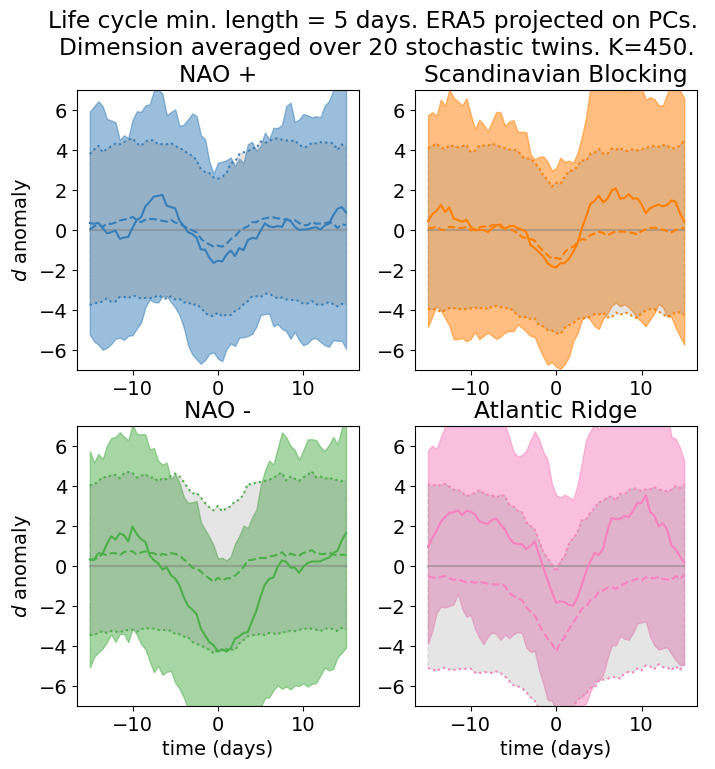

In [112]:
plt.figure(figsize=(8,8),dpi=100)
i_K = 30
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)
    
    plt.plot([-plot_length/2,plot_length/2] , [0]*2, '-', color='.5', alpha=.5)
    
    for j in range(2):
        if j == 0:
            plot_mean = np.mean( dd_plot_pcs[i_regime][:,:,i_K] , axis = 0)
            plot_std = np.std( dd_plot_pcs[i_regime][:,:,i_K] , axis = 0)
        else:
            plot_mean = np.mean( dd_plot_twin_concat[i_regime][:,:,i_K] , axis = 0)
            plot_std = np.std( dd_plot_twin_concat[i_regime][:,:,i_K] , axis = 0)
            
        plt.plot(t_plot, plot_mean, ['-','--'][j], color=cols[i_regime+1])
        plt.fill_between(t_plot, plot_mean - plot_std, plot_mean + plot_std,
                         ls = ['-','--'][j] , color=[cols[i_regime+1],'0.5'][j], alpha=[.5,.2][j])
        if j==1:
            plt.plot(t_plot, plot_mean - plot_std , ':', color=cols[i_regime+1])
            plt.plot(t_plot, plot_mean + plot_std , ':', color=cols[i_regime+1])
            
    plt.xlabel('time (days)'*( i_regime > 1 ))
    plt.ylabel(r'$d$ anomaly'*( i_regime % 2 == 0 ))
    plt.ylim([-7,7])
    plt.title(regime_names[i_regime])

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days. '
            +'ERA5 projected on PCs. \n'
            +'Dimension averaged over '+str(Ntwins)+' stochastic twins. K='+str(K[i_K])+'.')
plt.savefig(figure_folder + 'd_life-cycle_twins_only.png', dpi=150, bbox_inches='tight')
plt.show()

## IV.C. Relationship between dimension anomaly at peak WRI and peak WRI

### IV.C.1. Plots using stochastic twins as analogues of ERA5 projected data

In [21]:
# recompute for these plots because we need 1-day cycles
# # minimum length of life-cycle
LC_length = 1*2
# # minimum value of IWR for life-cycle definitino
thresh_IWR = 1
# # (half of whole) length over which to plot characteristics
plot_length = 15*2
t_plot = np.arange( - plot_length , plot_length + 1 )/2

IWR_plot_nat = []

dd_plot_nat = []
dd_plot_pcs = []
dd_plot_nat_twin = []

for i_regime in range(len(means)):
    
    IWR_plot__ = []
    dd_plot_nat__ = []
    dd_plot_pcs__ = []
    dd_plot_nat_twin__ = []
    
    
    t = np.array(plot_length) + 5
    while t < int(L) - 5 - max(LC_length , plot_length + 1):
        t += 1
        if np.product( index_nat[t:t+LC_length,i_regime] > thresh_IWR ):
            t_start = t.copy()
            t_end = t_start+LC_length
            while index_nat[t_end,i_regime] > thresh_IWR and t_end + 1 < L :
                t_end += 1
            t_max = t_start + np.argmax(index_nat[t_start:t_end,i_regime])
            
            if t_max < int(L) + 1 - plot_length:
                
                IWR_plot__.append( index_nat[t_max-plot_length:t_max+plot_length+1] )
                
                dd_plot_nat__.append( dd_nat_anom[t_max-plot_length:t_max+plot_length+1] )
                dd_plot_pcs__.append( dd_pcs_anom[t_max-plot_length:t_max+plot_length+1] )
                dd_plot_nat_twin__.append( dd_nat_twin_anom[:,t_max-plot_length:t_max+plot_length+1] )
                
            t = t_end.copy()
    
    IWR_plot_nat.append( IWR_plot__ )
    
    dd_plot_nat.append( np.array(dd_plot_nat__) )
    dd_plot_pcs.append( np.array(dd_plot_pcs__) )
    dd_plot_nat_twin.append( np.array(dd_plot_nat_twin__) )

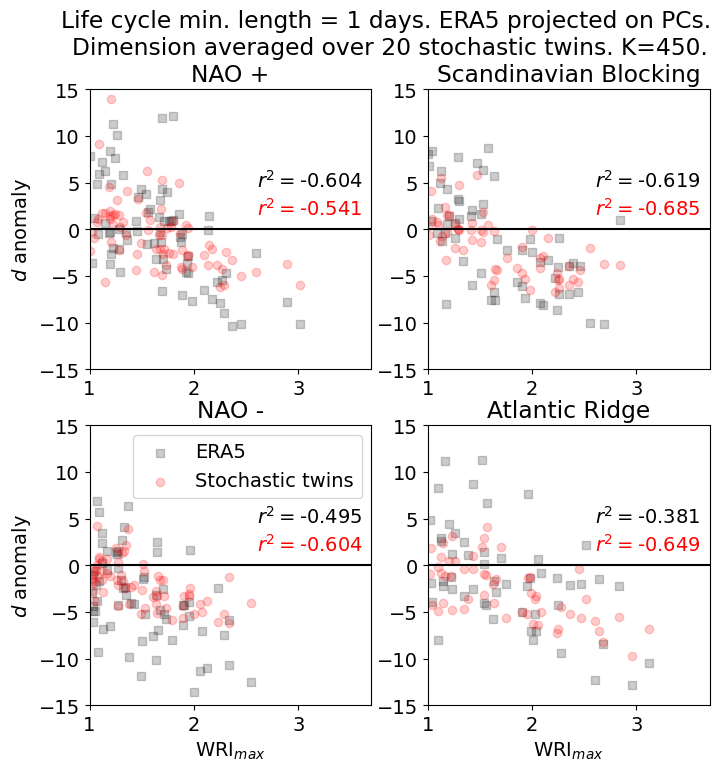

In [30]:
plt.figure(figsize=(8,8),dpi=100)
i_K = 30
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)
        
    for j in range(2):
        
        if j == 0:
            x_plot = np.array(IWR_plot_nat[i_regime])[:,plot_length,i_regime]
            y_plot = dd_plot_pcs[i_regime][:,plot_length,i_K]
        else:
            x_plot = np.array(IWR_plot_nat[i_regime])[:,plot_length,i_regime]
            y_plot = np.mean( dd_plot_nat_twin[i_regime][:,:,plot_length,i_K] , axis=1 )
    
        plt.scatter( x_plot , y_plot ,
                    marker = ['s','o'][j], color=['k','r'][j], alpha=.2, label=['ERA5','Stochastic twins'][j])
        
        plt.text( 2.6 , [4.5,1.5][j] , r'$r^2=$' + str( np.corrcoef( x_plot , y_plot )[0,1] )[:6],
               color=['k','r'][j])
        
    if i_regime == 2:
        plt.legend()
    plt.xlabel(r'WRI$_{max}$'*( i_regime > 1 ))
    plt.ylabel(r'$d$ anomaly'*( i_regime % 2 == 0 ))
    plt.plot([1,4], [0,0], '-k')
    plt.ylim([-15,15])
    plt.xlim([1,3.7])
    plt.title(regime_names[i_regime])
#     plt.grid()

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days. '
            +'ERA5 projected on PCs. \n'
            +'Dimension averaged over '+str(Ntwins)+' stochastic twins. K='+str(K[i_K])+'.')
plt.savefig(figure_folder + 'd_peak_WRI.png', bbox_inches='tight', dpi=150)
plt.show()

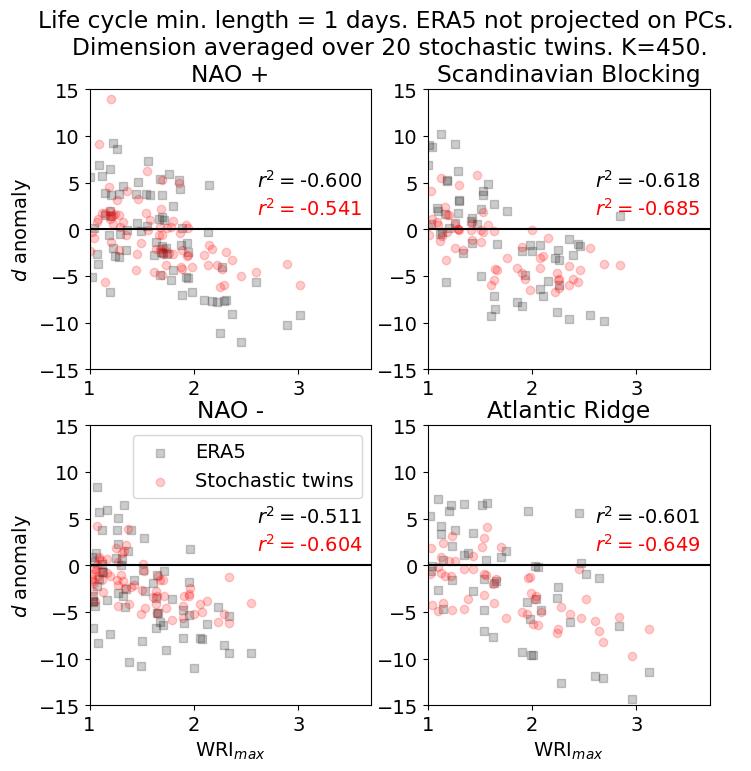

In [40]:
plt.figure(figsize=(8,8),dpi=100)
i_K = 30
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)
        
    for j in range(2):
        
        if j == 0:
            x_plot = np.array(IWR_plot_nat[i_regime])[:,plot_length,i_regime]
            y_plot = dd_plot_nat[i_regime][:,plot_length,i_K]
        else:
            x_plot = np.array(IWR_plot_nat[i_regime])[:,plot_length,i_regime]
            y_plot = np.mean( dd_plot_nat_twin[i_regime][:,:,plot_length,i_K] , axis=1 )
    
        plt.scatter( x_plot , y_plot ,
                    marker = ['s','o'][j], color=['k','r'][j], alpha=.2, label=['ERA5','Stochastic twins'][j])
        
        plt.text( 2.6 , [4.5,1.5][j] , r'$r^2=$' + str( np.corrcoef( x_plot , y_plot )[0,1] )[:6],
               color=['k','r'][j])
        
    if i_regime == 2:
        plt.legend()
    plt.xlabel(r'WRI$_{max}$'*( i_regime > 1 ))
    plt.ylabel(r'$d$ anomaly'*( i_regime % 2 == 0 ))
    plt.plot([1,4], [0,0], '-k')
    plt.ylim([-15,15])
    plt.xlim([1,3.7])
    plt.title(regime_names[i_regime])
#     plt.grid()

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days. '
            +'ERA5 not projected on PCs. \n'
            +'Dimension averaged over '+str(Ntwins)+' stochastic twins. K='+str(K[i_K])+'.')
plt.savefig(figure_folder + 'd_peak_WRI_ERAnotproj.png', bbox_inches='tight', dpi=150)
plt.show()

### IV.C.2. Repeat plots but for stochastic data alone, w/o using ERA5

In [31]:
# # minimum length of life-cycle
LC_length = 1*2
# # minimum value of IWR for life-cycle definitino
thresh_IWR = 1
# # (half of whole) length over which to plot characteristics
plot_length = 15*2
t_plot = np.arange( - plot_length , plot_length + 1 )/2

IWR_plot_twin = []
dd_plot_twin = []
    
for k in tqdm(range(Ntwins)):
    IWR_plot_ = []
    dd_plot_twin_ = []
    
    for i_regime in range(len(means)):

        IWR_plot__ = []
        dd_plot_twin__ = []

        t = np.array(plot_length) + 5
        while t < int(L) - 5 - max(LC_length , plot_length + 1):
            t += 1
            if np.product( index[k][t:t+LC_length,i_regime] > thresh_IWR ):
                t_start = t.copy()
                t_end = t_start+LC_length
                while index[k][t_end,i_regime] > thresh_IWR and t_end + 1 < L :
                    t_end += 1
                t_max = t_start + np.argmax(index[k][t_start:t_end,i_regime])

                if t_max < int(L) + 1 - plot_length:

                    IWR_plot__.append( index[k][t_max-plot_length:t_max+plot_length+1] )

                    dd_plot_twin__.append( dd_twin_anom[k,t_max-plot_length:t_max+plot_length+1] )

                t = t_end.copy()

        IWR_plot_.append( IWR_plot__ )
        dd_plot_twin_.append( np.array(dd_plot_twin__) )
        
    IWR_plot_twin.append( IWR_plot_ )
    dd_plot_twin.append( dd_plot_twin_ )

# Intra-twin statistics
IWR_mean_twin = np.zeros( ( Ntwins , nclus , len(t_plot) , nclus ) , dtype='float64' )
IWR_std_twin = np.zeros( ( Ntwins , nclus , len(t_plot) , nclus ) , dtype='float64' )

dd_mean_twin = np.zeros( ( Ntwins , nclus , len(t_plot) , len(K) ) , dtype='float64' )
dd_std_twin = np.zeros( ( Ntwins , nclus , len(t_plot) , len(K) ) , dtype='float64' )

for k in range(Ntwins):
    for i in range(nclus):
        IWR_mean_twin[k,i] = np.mean( np.array(IWR_plot_twin[k][i]) , axis=0 )
        IWR_std_twin[k,i] = np.std( np.array(IWR_plot_twin[k][i]) , axis=0 )     
        
        dd_mean_twin[k,i] = np.mean( np.array(dd_plot_twin[k][i]) , axis=0 )
        dd_std_twin[k,i] = np.std( np.array(dd_plot_twin[k][i]) , axis=0 )        


# Merge all twins
IWR_plot_twin_concat = []
dd_plot_twin_concat = []

for i_regime in range(len(means)):
    IWR_plot_twin_concat__ = []
    dd_plot_twin_concat__ = []
    
    for k in range(Ntwins):
        for l in range(len(IWR_plot_twin[k][i_regime])):
            IWR_plot_twin_concat__.append( IWR_plot_twin[k][i_regime][l] )
            dd_plot_twin_concat__.append( dd_plot_twin[k][i_regime][l] )

    IWR_plot_twin_concat.append( IWR_plot_twin_concat__ )
    dd_plot_twin_concat.append( np.array(dd_plot_twin_concat__) )    

  0%|          | 0/20 [00:00<?, ?it/s]

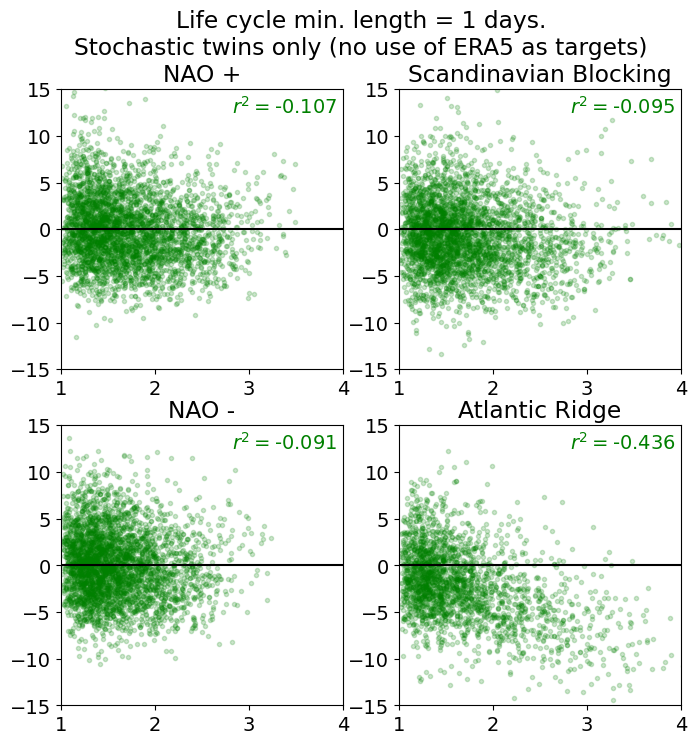

In [39]:
plt.figure(figsize=(8,8),dpi=100)
i_K = 30
for i_regime in range(len(weights)):
    plt.subplot(221+i_regime)

    x_plot = np.array(IWR_plot_twin_concat[i_regime])[:,plot_length,i_regime]
    y_plot = dd_plot_twin_concat[i_regime][:,plot_length,i_K]
    
    plt.scatter( x_plot , y_plot ,
                marker = '.', color='g', alpha=.2)
    
    plt.text( 2.82 , 12.5 , r'$r^2=$' + str( np.corrcoef( x_plot , y_plot )[0,1] )[:6],
           color='g',)
            
    plt.plot([1,4], [0,0], '-k')
    plt.ylim([-15,15])
    plt.xlim([1,4])
    plt.title(regime_names[i_regime])

plt.suptitle('Life cycle min. length = '+str(int(LC_length/2))+' days.\n'
            +'Stochastic twins only (no use of ERA5 as targets)')
#             +'ERA5 projected on PCs')
plt.savefig(figure_folder + 'd_peak_WRI_twins.png', dpi=150, bbox_inches='tight')
plt.show()